
The project is to **predict whether or not an individual will suffer a stroke.**

First, We will perform extensive data visualization. This will help me to see if there are any features that look to be indicative of a stroke, or indeed of not having a stroke.

Next, we will build multiple models and select the best performing one. we will use f1 score as my primary metric as our dataset is imbalanced (though we will also resolve this with SMOTE).

# Model Interpretation

**We will also delve in to Model Interpretation**
This is incfedibly important in industry. Often we need to explain very technical algorithms to a non-technical audience, so any tool that can help this process should be mastered.




In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
from imblearn.over_sampling import SMOTE
import scikitplot as skplt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
import warnings
warnings.filterwarnings('ignore')
!pip install pywaffle

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv
     |████████████████████████████████| 526 kB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


# Missing Data

In [ ]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

**How can we deal with blanks in our data?**

There are many ways. One can simply drop these records, fill the blanks with the mean, the median, or even simply the record before or after the missing value.

But there are other, more unusual ways.

Here I will use a **Decision Tree to predict the missing BMI**

Other interesting methods to explore could include using K-Nearest-Neighbours to fill the gaps.

In [ ]:
# A really fantsatic and intelligent way to deal with blanks, from Thoman Konstantin in: https://www.kaggle.com/thomaskonstantin/analyzing-and-modeling-stroke-data

# scaling the data and training a Decision Tree Regressor
DT_bmi_pipe = Pipeline( steps=[
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])

X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]

X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [ ]:
print('Missing values: ',sum(df.isnull().sum()))

Missing values:  0


We've **replaced all missing values**

Now we can move to the next step

# Exploring the data

We have now dealt with the missing values in the data.

Next, I want to **explore** the data.

Does age makes one more likely to suffer a stroke? What about gender? Or BMI?

These are all questions that can be explored and answered with some data visulization.

First, let's look at the numeric/continuous variable distribtion

In [ ]:
variables = [variable for variable in df.columns if variable not in ['id','stroke']]

conts = ['age','avg_glucose_level','bmi']

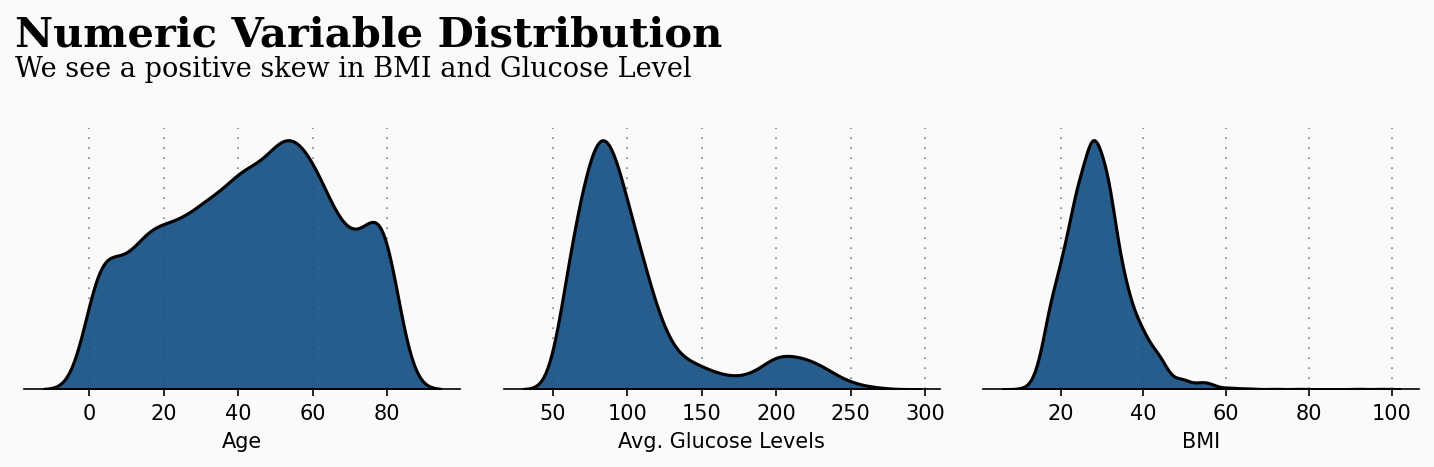

In [ ]:
fig = plt.figure(figsize=(12, 12), dpi=150, facecolor='#fafafa')
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

background_color = "#fafafa"

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0
for variable in conts:
        sns.kdeplot(df[variable] ,ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        #locals()["ax"+str(plot)].set_xlabel(variable) removed this for aesthetics
        plot += 1

ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')


ax0.text(-20, 0.022, 'Numeric Variable Distribution', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-20, 0.02, 'We see a positive skew in BMI and Glucose Level', fontsize=13, fontweight='light', fontfamily='serif')

plt.show()

So we've **gained some understanding** on the distributiona of our numeric variables, **but we can add more information** to this plot.

Let's see how the distribution of our numeric variables is different for **those that have strokes, and those that do not.**

This could be important for modelling later on

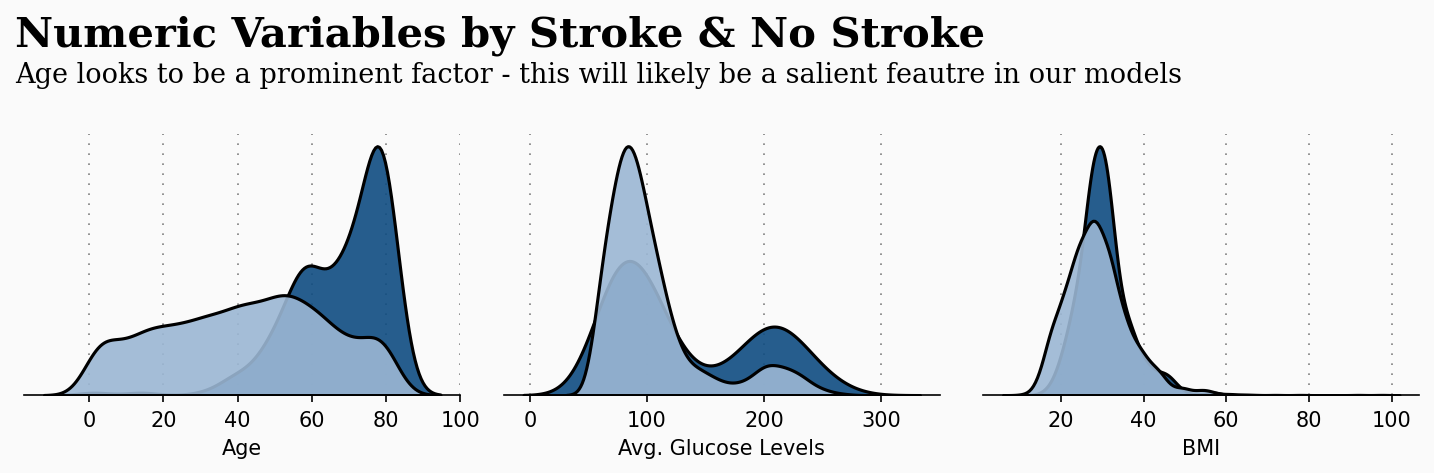

In [ ]:
fig = plt.figure(figsize=(12, 12), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)


plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

s = df[df['stroke'] == 1]
ns = df[df['stroke'] == 0]

for feature in conts:
        sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(ns[feature],ax=locals()["ax"+str(plot)], color='#9bb7d4', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        #locals()["ax"+str(plot)].set_xlabel(feature)
        plot += 1

ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')

ax0.text(-20, 0.056, 'Numeric Variables by Stroke & No Stroke', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-20, 0.05, 'Age looks to be a prominent factor - this will likely be a salient feautre in our models',
         fontsize=13, fontweight='light', fontfamily='serif')

plt.show()


# Insight

Based on the above plots, it seems clear that **Age is a big factor** in stroke patients - the older you get the more at risk you are.

Though less obvious, there are also differences in Avg. Glucose Levels and BMI.

Let's explore those variables further...

In [ ]:
str_only = df[df['stroke'] == 1]
no_str_only = df[df['stroke'] == 0]

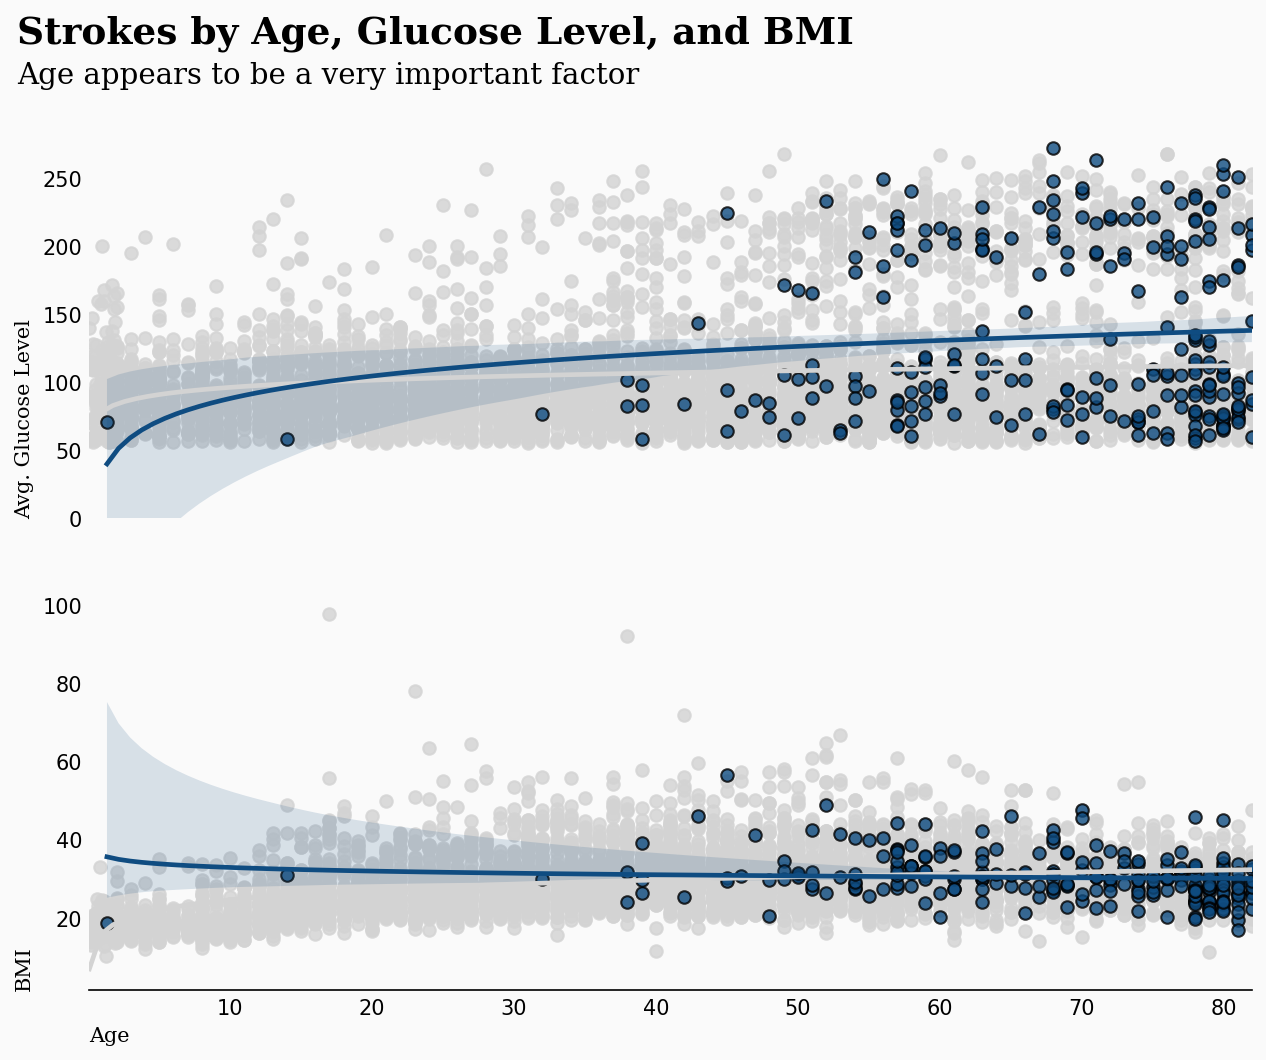

In [ ]:
# Setting up figure and axes

fig = plt.figure(figsize=(10,16),dpi=150,facecolor=background_color)
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.5, hspace=0.2)
ax0 = fig.add_subplot(gs[0, 0:2])
ax1 = fig.add_subplot(gs[1, 0:2])

ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

# glucose

sns.regplot(no_str_only['age'],y=no_str_only['avg_glucose_level'],
            color='lightgray',
            logx=True,
            ax=ax0)

sns.regplot(str_only['age'],y=str_only['avg_glucose_level'],
            color='#0f4c81',
            logx=True,scatter_kws={'edgecolors':['black'],
                                              'linewidth': 1},
            ax=ax0)

ax0.set(ylim=(0, None))
ax0.set_xlabel(" ",fontsize=12,fontfamily='serif')
ax0.set_ylabel("Avg. Glucose Level",fontsize=10,fontfamily='serif',loc='bottom')

ax0.tick_params(axis='x', bottom=False)
ax0.get_xaxis().set_visible(False)

for s in ['top','left','bottom']:
    ax0.spines[s].set_visible(False)


# bmi
sns.regplot(no_str_only['age'],y=no_str_only['bmi'],
            color='lightgray',
            logx=True,
            ax=ax1)

sns.regplot(str_only['age'],y=str_only['bmi'],
            color='#0f4c81', scatter_kws={'edgecolors':['black'],
                                              'linewidth': 1},
            logx=True,
            ax=ax1)

ax1.set_xlabel("Age",fontsize=10,fontfamily='serif',loc='left')
ax1.set_ylabel("BMI",fontsize=10,fontfamily='serif',loc='bottom')


for s in ['top','left','right']:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)


ax0.text(-5,350,'Strokes by Age, Glucose Level, and BMI',fontsize=18,fontfamily='serif',fontweight='bold')
ax0.text(-5,320,'Age appears to be a very important factor',fontsize=14,fontfamily='serif')


ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)



plt.show()

As we suspected, Age is a big factor, and also has slight relationships with BMI & Avg. Glucose levels.

We might understand intuitively that **as Age increases, the risk of having a stroke increases too, but can ve visualise this?**

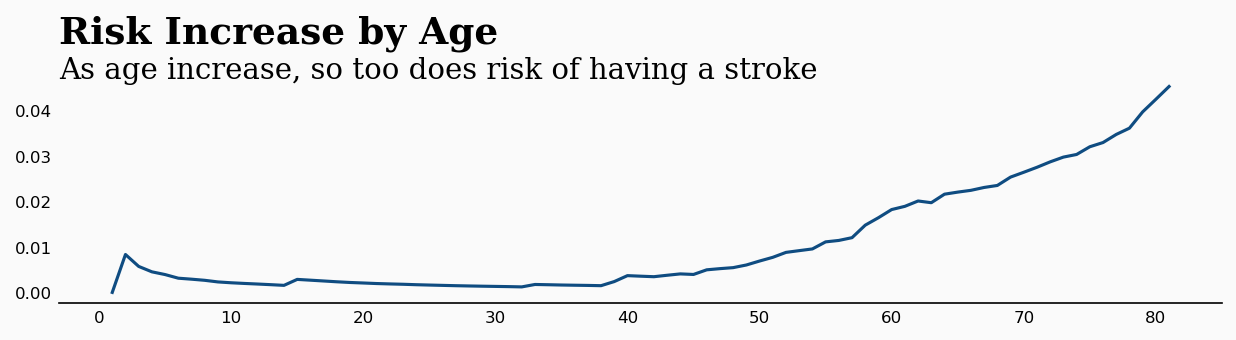

In [ ]:
fig = plt.figure(figsize=(10, 5), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0.11, hspace=0.5)
ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)


df['age'] = df['age'].astype(int)

rate = []
for i in range(df['age'].min(), df['age'].max()):
    rate.append(df[df['age'] < i]['stroke'].sum() / len(df[df['age'] < i]['stroke'])) # % of stroke at a certain age

sns.lineplot(data=rate,color='#0f4c81',ax=ax0)

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)

ax0.tick_params(axis='both', which='major', labelsize=8)
ax0.tick_params(axis=u'both', which=u'both',length=0)

ax0.text(-3,0.055,'Risk Increase by Age',fontsize=18,fontfamily='serif',fontweight='bold')
ax0.text(-3,0.047,'As age increase, so too does risk of having a stroke',fontsize=14,fontfamily='serif')


plt.show()

This confirms what our intuitions told us. The older you get, the more at risk you get.

However, you may have notices the low risk values on the y-axis. This is because the **dataset is highly imbalanced**.

Only 249 strokes are in our dataset which totals 5000 - around 1 in 20.

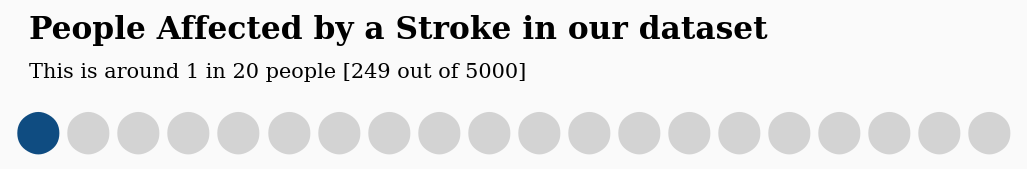

In [ ]:
from pywaffle import Waffle

fig = plt.figure(figsize=(7, 2),dpi=150,facecolor=background_color,
    FigureClass=Waffle,
    rows=1,
    values=[1, 19],
    colors=['#0f4c81', "lightgray"],
    characters='⬤',
    font_size=20,vertical=True,
)

fig.text(0.035,0.78,'People Affected by a Stroke in our dataset',fontfamily='serif',fontsize=15,fontweight='bold')
fig.text(0.035,0.65,'This is around 1 in 20 people [249 out of 5000]',fontfamily='serif',fontsize=10)

plt.show()

This needs to be considered when modelling of course, but also when formulating risk.

Strokes are still relatively rare, we are not saying anything is guaranteed, just that risk is increasing.

In [ ]:
# Drop single 'Other' gender
no_str_only = no_str_only[(no_str_only['gender'] != 'Other')]

# General Overview

We've assessed a few variables so far, and gained some powerful insights.

I'll now plot several variables in one place, so we can spot interesting trends or features.

I will split the data in to 'Stroke' and 'No-Stroke' so we can see if these two populations differ in any meaningful way.

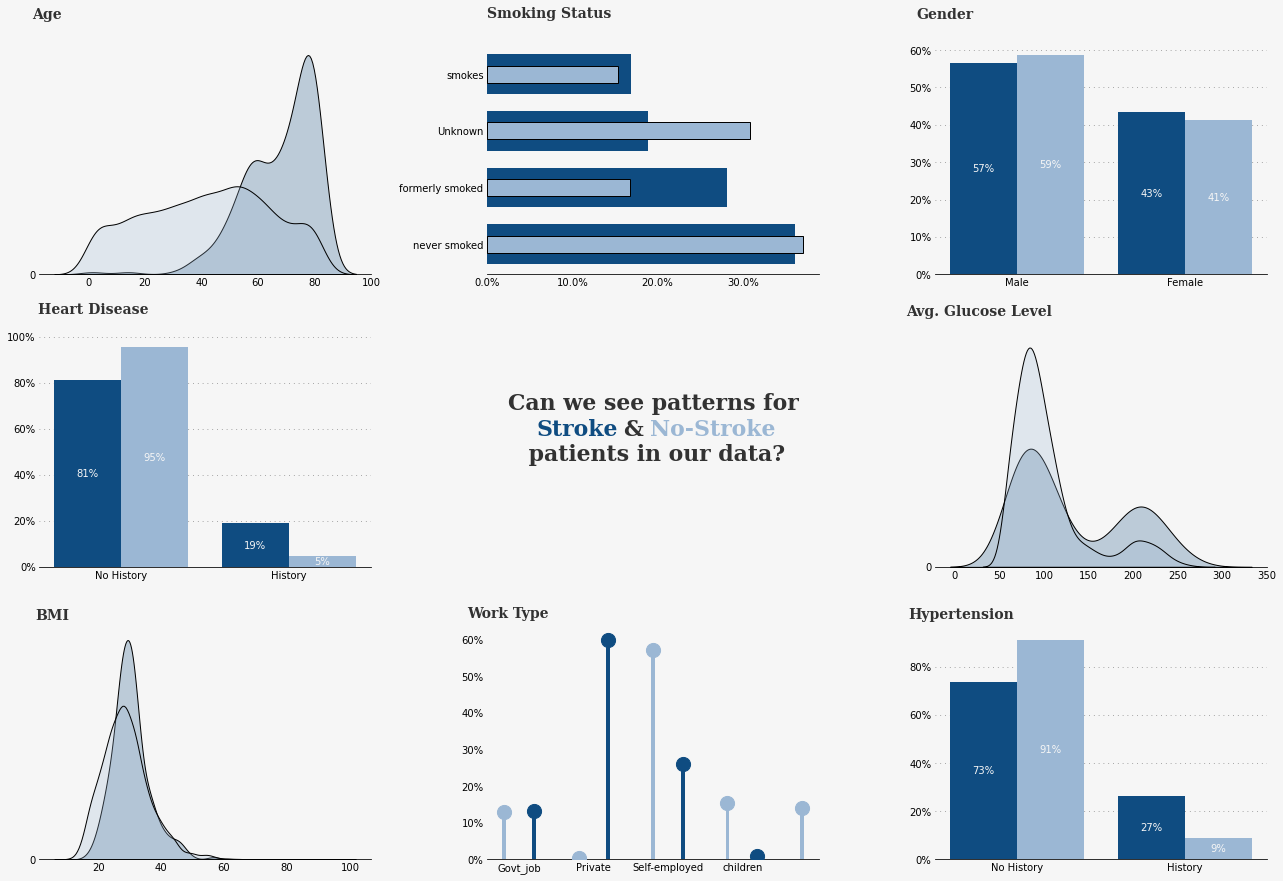

In [ ]:
fig = plt.figure(figsize=(22,15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])

background_color = "#f6f6f6"
fig.patch.set_facecolor(background_color) # figure background color


# Plots

## Age


ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["age"])
negative = pd.DataFrame(no_str_only["age"])
sns.kdeplot(positive["age"], ax=ax0,color="#0f4c81", shade=True, ec='black',label="positive")
sns.kdeplot(negative["age"], ax=ax0, color="#9bb7d4", shade=True, ec='black',label="negative")
#ax3.text(0.29, 13, 'Age',
 #        fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax0.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax0.set_ylabel('')
ax0.set_xlabel('')
ax0.text(-20, 0.0465, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")



# Smoking
positive = pd.DataFrame(str_only["smoking_status"].value_counts())
positive["Percentage"] = positive["smoking_status"].apply(lambda x: x/sum(positive["smoking_status"])*100)
negative = pd.DataFrame(no_str_only["smoking_status"].value_counts())
negative["Percentage"] = negative["smoking_status"].apply(lambda x: x/sum(negative["smoking_status"])*100)

ax1.text(0, 4, 'Smoking Status', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax1.barh(positive.index, positive['Percentage'], color="#0f4c81", zorder=3, height=0.7)
ax1.barh(negative.index, negative['Percentage'], color="#9bb7d4", zorder=3,ec='black', height=0.3)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.xaxis.set_major_locator(mtick.MultipleLocator(10))

##
# Ax2 - GENDER
positive = pd.DataFrame(str_only["gender"].value_counts())
positive["Percentage"] = positive["gender"].apply(lambda x: x/sum(positive["gender"])*100)
negative = pd.DataFrame(no_str_only["gender"].value_counts())
negative["Percentage"] = negative["gender"].apply(lambda x: x/sum(negative["gender"])*100)

x = np.arange(len(positive))
ax2.text(-0.4, 68.5, 'Gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax2.bar(x, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax2.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.4)
ax2.set_xticks(x + 0.4 / 2)
ax2.set_xticklabels(['Male','Female'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))
for i,j in zip([0, 1], positive["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')



# Heart Dis

positive = pd.DataFrame(str_only["heart_disease"].value_counts())
positive["Percentage"] = positive["heart_disease"].apply(lambda x: x/sum(positive["heart_disease"])*100)
negative = pd.DataFrame(no_str_only["heart_disease"].value_counts())
negative["Percentage"] = negative["heart_disease"].apply(lambda x: x/sum(negative["heart_disease"])*100)

x = np.arange(len(positive))
ax3.text(-0.3, 110, 'Heart Disease', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax3.bar(x, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax3.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.4)
ax3.set_xticks(x + 0.4 / 2)
ax3.set_xticklabels(['No History','History'])
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i,j in zip([0, 1], positive["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax3.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')


## AX4 - TITLE

ax4.spines["bottom"].set_visible(False)
ax4.tick_params(left=False, bottom=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.text(0.5, 0.6, 'Can we see patterns for\n\n patients in our data?', horizontalalignment='center', verticalalignment='center',
         fontsize=22, fontweight='bold', fontfamily='serif', color="#323232")

ax4.text(0.15,0.57,"Stroke", fontweight="bold", fontfamily='serif', fontsize=22, color='#0f4c81')
ax4.text(0.41,0.57,"&", fontweight="bold", fontfamily='serif', fontsize=22, color='#323232')
ax4.text(0.49,0.57,"No-Stroke", fontweight="bold", fontfamily='serif', fontsize=22, color='#9bb7d4')


# Glucose

ax5.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["avg_glucose_level"])
negative = pd.DataFrame(no_str_only["avg_glucose_level"])
sns.kdeplot(positive["avg_glucose_level"], ax=ax5,color="#0f4c81",ec='black', shade=True, label="positive")
sns.kdeplot(negative["avg_glucose_level"], ax=ax5, color="#9bb7d4", ec='black',shade=True, label="negative")
ax5.text(-55, 0.01855, 'Avg. Glucose Level',
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax5.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax5.set_ylabel('')
ax5.set_xlabel('')



## BMI


ax6.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["bmi"])
negative = pd.DataFrame(no_str_only["bmi"])
sns.kdeplot(positive["bmi"], ax=ax6,color="#0f4c81", ec='black',shade=True, label="positive")
sns.kdeplot(negative["bmi"], ax=ax6, color="#9bb7d4",ec='black', shade=True, label="negative")
ax6.text(-0.06, 0.09, 'BMI',
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax6.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax6.set_ylabel('')
ax6.set_xlabel('')


# Work Type

positive = pd.DataFrame(str_only["work_type"].value_counts())
positive["Percentage"] = positive["work_type"].apply(lambda x: x/sum(positive["work_type"])*100)
positive = positive.sort_index()

negative = pd.DataFrame(no_str_only["work_type"].value_counts())
negative["Percentage"] = negative["work_type"].apply(lambda x: x/sum(negative["work_type"])*100)
negative = negative.sort_index()

ax7.bar(negative.index, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.05)
ax7.scatter(negative.index, negative["Percentage"], zorder=3,s=200, color="#9bb7d4")
ax7.bar(np.arange(len(positive.index))+0.4, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.05)
ax7.scatter(np.arange(len(positive.index))+0.4, positive["Percentage"], zorder=3,s=200, color="#0f4c81")

ax7.yaxis.set_major_formatter(mtick.PercentFormatter())
ax7.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax7.set_xticks(np.arange(len(positive.index))+0.4 / 2)
ax7.set_xticklabels(list(positive.index),rotation=0)
ax7.text(-0.5, 66, 'Work Type', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")



# hypertension

positive = pd.DataFrame(str_only["hypertension"].value_counts())
positive["Percentage"] = positive["hypertension"].apply(lambda x: x/sum(positive["hypertension"])*100)
negative = pd.DataFrame(no_str_only["hypertension"].value_counts())
negative["Percentage"] = negative["hypertension"].apply(lambda x: x/sum(negative["hypertension"])*100)

x = np.arange(len(positive))
ax8.text(-0.45, 100, 'Hypertension', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax8.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax8.bar(x, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax8.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.4)
ax8.set_xticks(x + 0.4 / 2)
ax8.set_xticklabels(['No History','History'])
ax8.yaxis.set_major_formatter(mtick.PercentFormatter())
ax8.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i,j in zip([0, 1], positive["Percentage"]):
    ax8.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax8.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')


# tidy up



for s in ["top","right","left"]:
    for i in range(0,9):
        locals()["ax"+str(i)].spines[s].set_visible(False)

for i in range(0,9):
        locals()["ax"+str(i)].set_facecolor(background_color)
        locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)
        locals()["ax"+str(i)].set_facecolor(background_color)


plt.show()

# Insights

The plots above are quite enlightening.

As discussed earlier, we again note the importance of Age, amongst other things.

# Model preparation

In [ ]:
# Encoding categorical values

df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)

# Modelling

# Can we predict whether or not an indiviudal will suffer a stroke?

First, I will use the SMOTE (Synthetic Minority Over-sampling Technique) to balance our dataset.

Currently, as I mentioned above, there are many more negative examples of a stroke and this could hinder our model.

This can be addressed using SMOTE.

# Baseline

For such an imbalanced dataset, a useful baseline can be to beat the 'Null Accuracy', and in our case, since we're looking for the positive ('stroke'), I will take the inverse of that.
In other words, always predicting the most common outcome.

For this case, 249/(249+4861) = 0.048

So a good target to beat would be 5%~ for recall for positive stroke patients.

In [ ]:
# Inverse of Null Accuracy
print('Inverse of Null Accuracy: ',249/(249+4861))
print('Null Accuracy: ',4861/(4861+249))

Inverse of Null Accuracy:  0.0487279843444227
Null Accuracy:  0.9512720156555773


In [ ]:
X  = df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']]
y = df['stroke']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

In [ ]:
X_test.head(2)

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi
4688,0,31,0,0,1,64.85,23.0
4478,0,40,0,0,1,65.29,28.3


Method 1: Simple Oversampling, which duplicating existing samples, which can lead to overfitting.

SMOTE (Synthetic Minority Over-sampling Technique) is a method for oversampling the minority class by generating synthetic samples rather than duplicating existing ones.

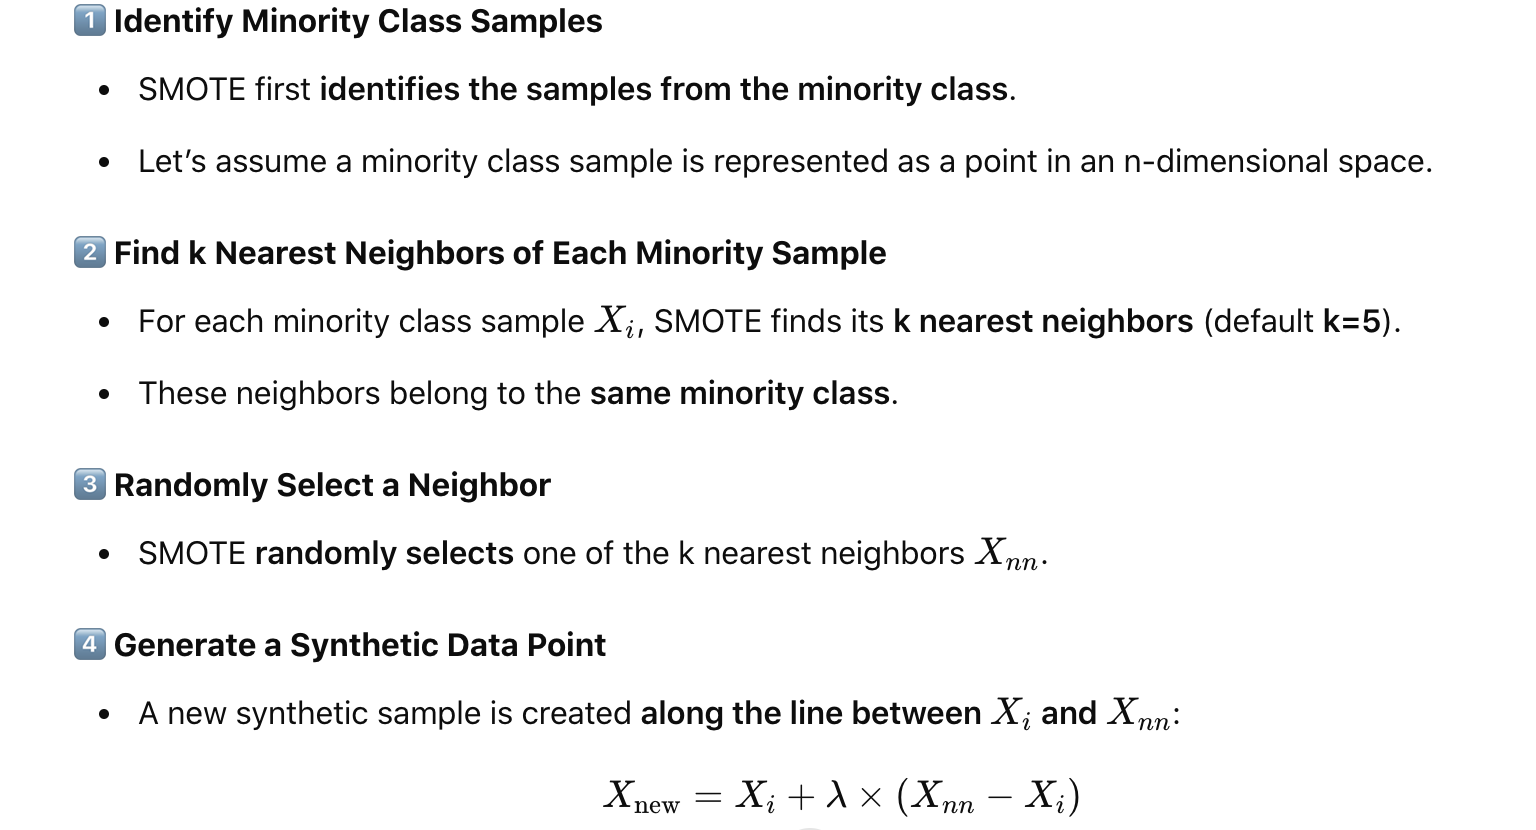

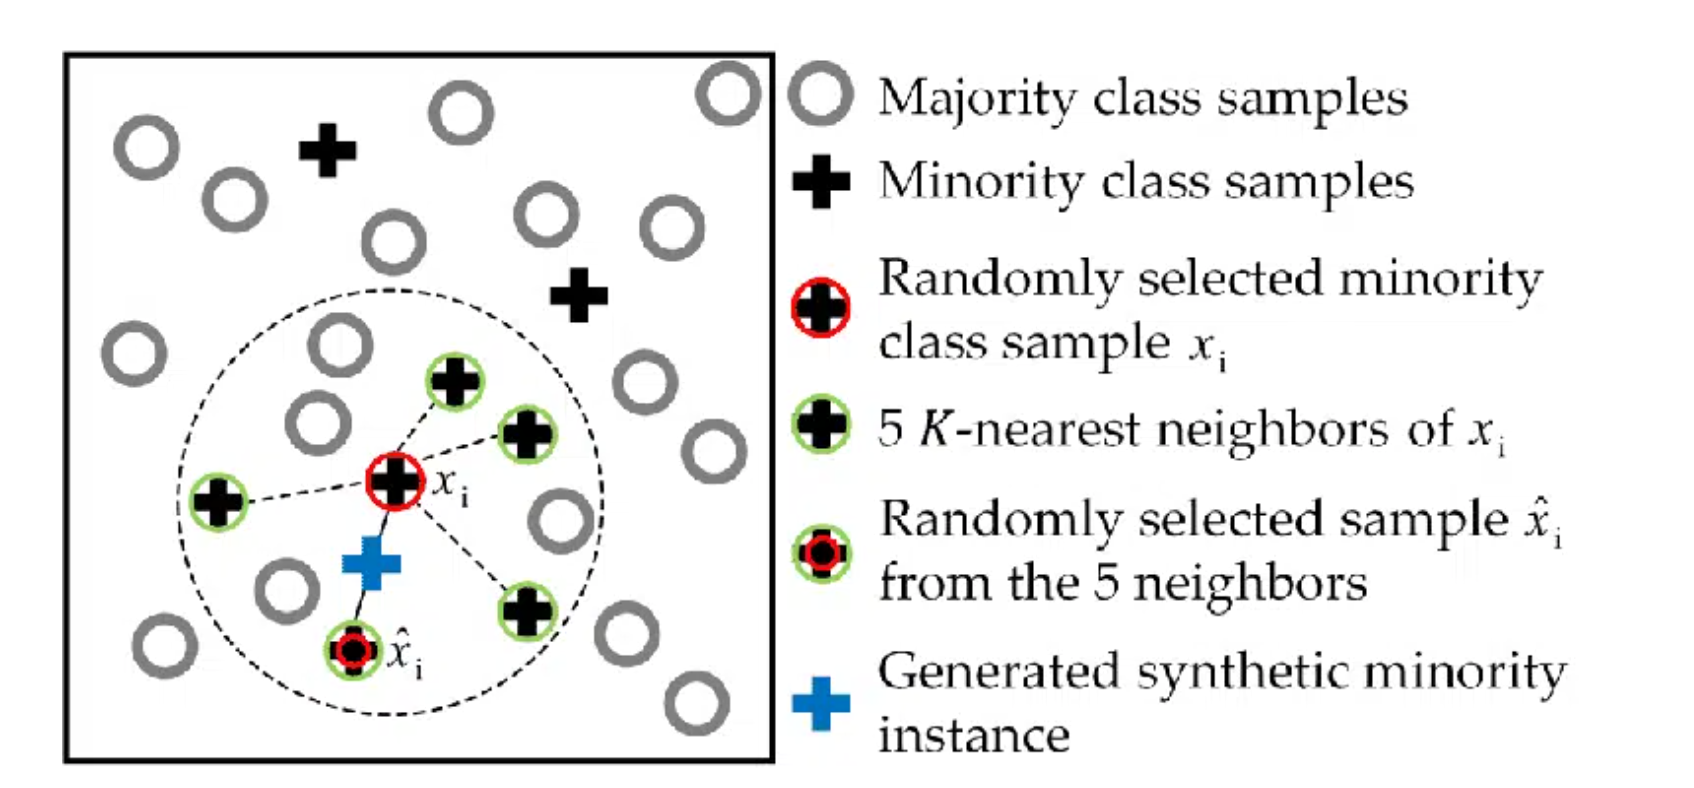

In [ ]:
# Our data is biased, we can fix this with SMOTE

oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

Our data is now equal

# Models

I will model Random Forest, SVM, and Logisitc Regression for this classificatioin task.

In addition, I will utilise 10 fold cross validation.

In [ ]:
# Models

# Scale our data in pipeline, then split

rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(random_state=42))])
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])



#X = upsampled_df.iloc[:,:-1] # X_train_resh
#Y = upsampled_df.iloc[:,-1]# y_train_resh

#retain_x = X.sample(100)
#retain_y = Y.loc[X.index]

#X = X.drop(index=retain_x.index)
#Y = Y.drop(index=retain_x.index)

In [ ]:
#cross-validation,  splits data into 10 parts and trains on different subsets, using F1 score as final evaluation metric
rf_cv = cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
svm_cv = cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
logreg_cv = cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')

In [ ]:
print('Mean f1 scores:')
print('Random Forest mean :',cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('SVM mean :',cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('Logistic Regression mean :',cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())



Mean f1 scores:
Random Forest mean : 0.9342717632419655
SVM mean : 0.8752026263943018
Logistic Regression mean : 0.8225682495045643


# Random Forest performed the best

Often, tree methods will be the model of choice.

# Now let's try it on the unseen negative data


In [ ]:
rf_pipeline.fit(X_train_resh,y_train_resh)
svm_pipeline.fit(X_train_resh,y_train_resh)
logreg_pipeline.fit(X_train_resh,y_train_resh)

#X = df.loc[:,X.columns]
#Y = df.loc[:,'stroke']

rf_pred   =rf_pipeline.predict(X_test)
svm_pred  = svm_pipeline.predict(X_test)
logreg_pred   = logreg_pipeline.predict(X_test)

rf_cm  = confusion_matrix(y_test,rf_pred )
svm_cm = confusion_matrix(y_test,svm_pred)
logreg_cm  = confusion_matrix(y_test,logreg_pred )

rf_f1  = f1_score(y_test,rf_pred)
svm_f1 = f1_score(y_test,svm_pred)
logreg_f1  = f1_score(y_test,logreg_pred)

In [ ]:
print('Mean f1 scores:')

print('RF mean :',rf_f1)
print('SVM mean :',svm_f1)
print('LR mean :',logreg_f1)

Mean f1 scores:
RF mean : 0.16226415094339622
SVM mean : 0.15682281059063136
LR mean : 0.19360902255639098


In [ ]:
from sklearn.metrics import plot_confusion_matrix, classification_report

print(classification_report(y_test,rf_pred))

print('Accuracy Score: ',accuracy_score(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3404
           1       0.12      0.25      0.16       173

    accuracy                           0.88      3577
   macro avg       0.54      0.58      0.55      3577
weighted avg       0.92      0.88      0.90      3577

Accuracy Score:  0.8758736371260833


# Good accuracy, poor recall

I will try using a grid search to find the optimal parameters for our Random Forest

In [ ]:
# Pretty good accuracy, but poor recall!
# Unscaled and not upsampled negative

from sklearn.model_selection import GridSearchCV

n_estimators =[64,100,128,200]
max_features = [2,3,5,7]
bootstrap = [True,False]

param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap}

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
#grid = GridSearchCV(rfc,param_grid)

#grid.fit(X_train,y_train)

In [ ]:
#grid.best_params_

#{'bootstrap': True, 'max_features': 2, 'n_estimators': 100}

In [ ]:
# Let's use those params now

rfc = RandomForestClassifier(max_features=2,n_estimators=100,bootstrap=True)

rfc.fit(X_train_resh,y_train_resh)

rfc_tuned_pred = rfc.predict(X_test)

In [ ]:
print(classification_report(y_test,rfc_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test,rfc_tuned_pred))
print('F1 Score: ',f1_score(y_test,rfc_tuned_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3404
           1       0.11      0.23      0.15       173

    accuracy                           0.88      3577
   macro avg       0.54      0.57      0.54      3577
weighted avg       0.92      0.88      0.90      3577

Accuracy Score:  0.8764327648867767
F1 Score:  0.15325670498084293


# What about Logistic Regression?

Logistic Regression had the highest f1 score above, so perhaps we can tune that for better results.

In [ ]:
penalty = ['l1','l2']
C = [0.001, 0.01, 0.1, 1, 10, 100]

log_param_grid = {'penalty': penalty,
                  'C': C}
logreg = LogisticRegression()
grid = GridSearchCV(logreg,log_param_grid)

In [ ]:
#grid.fit(X_train_resh,y_train_resh)

In [ ]:
#grid.best_params_

#output:
# {'C': 0.1, 'penalty': 'l2'}

In [ ]:
# Let's use those params now

logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=0.1,penalty='l2',random_state=42))])

logreg_pipeline.fit(X_train_resh,y_train_resh)

#logreg.fit(X_train_resh,y_train_resh)

logreg_tuned_pred   = logreg_pipeline.predict(X_test)

In [ ]:
print(classification_report(y_test,logreg_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test,logreg_tuned_pred))
print('F1 Score: ',f1_score(y_test,logreg_tuned_pred))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      3404
           1       0.11      0.60      0.19       173

    accuracy                           0.76      3577
   macro avg       0.54      0.68      0.53      3577
weighted avg       0.93      0.76      0.83      3577

Accuracy Score:  0.7581772435001398
F1 Score:  0.19234360410831


So the hyper-parameter tuning has helped the Logisitc Regression model. It's recall score is much better than Random Forest's - even if the overall acuracy is down.

However, we can maniupulate the threshold that our model uses to classify stroke vs no-stroke.

# Try to optimize SVM

In [ ]:
# defining parameter range
#svm_param_grid = {'C': [0.1, 1, 10, 100, 1000],
          #    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
           #   'kernel': ['rbf']}

#svm = SVC(random_state=42)

#grid = GridSearchCV(svm,svm_param_grid)


In [ ]:
#grid.fit(X_train_resh,y_train_resh)

In [ ]:
#grid.best_params_

#output:
# {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

In [ ]:
# Let's use those params now

svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(C=1000,gamma=0.01,kernel='rbf',random_state=42))])

svm_pipeline.fit(X_train_resh,y_train_resh)

svm_tuned_pred   = svm_pipeline.predict(X_test)

In [ ]:
print(classification_report(y_test,svm_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test,svm_tuned_pred))
print('F1 Score: ',f1_score(y_test,svm_tuned_pred))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      3404
           1       0.09      0.43      0.15       173

    accuracy                           0.76      3577
   macro avg       0.53      0.60      0.50      3577
weighted avg       0.92      0.76      0.83      3577

Accuracy Score:  0.7598546267822197
F1 Score:  0.14866204162537164


# Now we have a decision to make...

The tuned Random Forest gave us a much higher accuracy score of around 94%, but with a recall for Stroke patients of 2%.

The original model had an accuracy of 88%, but a recall for stroke patients of 24%.

This is often where domain knowledge comes in to play.

**In my opinion**, the model is better off predicting those who will suffer a stroke, rather than predicting who will not.



In [ ]:
# Make dataframes to plot

rf_df = pd.DataFrame(data=[f1_score(y_test,rf_pred),accuracy_score(y_test, rf_pred), recall_score(y_test, rf_pred),
                   precision_score(y_test, rf_pred), roc_auc_score(y_test, rf_pred)],
             columns=['Random Forest Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

svm_df = pd.DataFrame(data=[f1_score(y_test,svm_pred),accuracy_score(y_test, svm_pred), recall_score(y_test, svm_pred),
                   precision_score(y_test, svm_pred), roc_auc_score(y_test, svm_pred)],
             columns=['Support Vector Machine (SVM) Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

lr_df = pd.DataFrame(data=[f1_score(y_test,logreg_tuned_pred),accuracy_score(y_test, logreg_tuned_pred), recall_score(y_test, logreg_tuned_pred),
                   precision_score(y_test, logreg_tuned_pred), roc_auc_score(y_test, logreg_tuned_pred)],
             columns=['Tuned Logistic Regression Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])



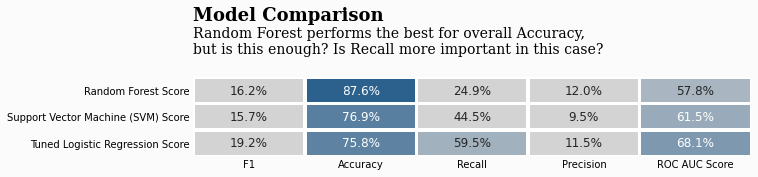

In [ ]:
df_models = round(pd.concat([rf_df,svm_df,lr_df], axis=1),3)
import matplotlib
colors = ["lightgray","lightgray","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,8)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

ax0.text(0,-2.15,'Model Comparison',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.text(0,-0.9,'Random Forest performs the best for overall Accuracy,\nbut is this enough? Is Recall more important in this case?',fontsize=14,fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)


plt.show()

# Model by Model Confusion Matrix

Now we have selected our models, we can view how they performed in each prediction.

A great way to visualise where your data performs well, and where it performs poorly.





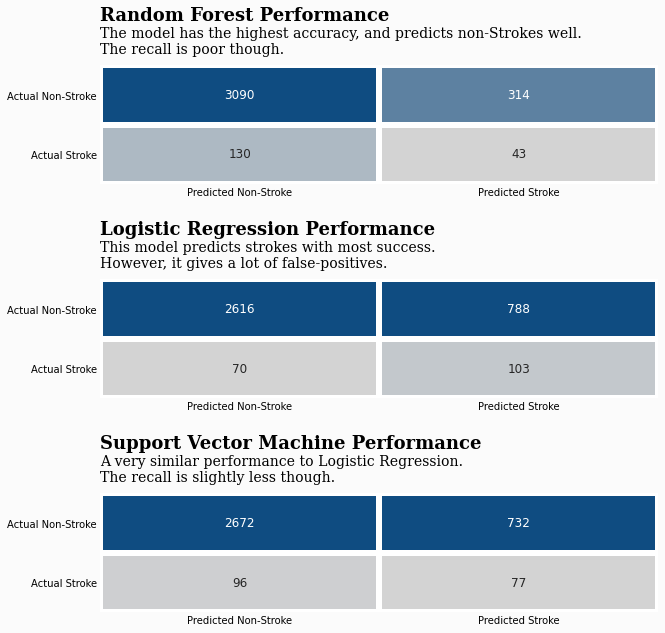

In [ ]:

# Plotting our results

colors = ["lightgray","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,14)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.8)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :])
ax0.set_facecolor(background_color) # axes background color

# Overall
sns.heatmap(rf_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax0,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})

sns.heatmap(logreg_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax1,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})

sns.heatmap(svm_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax2,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})



ax0.tick_params(axis=u'both', which=u'both',length=0)
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)
ax1.tick_params(axis=u'both', which=u'both',length=0)
ax1.set_facecolor(background_color)
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.set_facecolor(background_color)

ax0.text(0,-0.75,'Random Forest Performance',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.text(0,-0.2,'The model has the highest accuracy, and predicts non-Strokes well.\nThe recall is poor though.',fontsize=14,fontfamily='serif')

ax1.text(0,-0.75,'Logistic Regression Performance',fontsize=18,fontweight='bold',fontfamily='serif')
ax1.text(0,-0.2,'This model predicts strokes with most success.\nHowever, it gives a lot of false-positives.',fontsize=14,fontfamily='serif')

ax2.text(0,-0.75,'Support Vector Machine Performance',fontsize=18,fontweight='bold',fontfamily='serif')
ax2.text(0,-0.2,'A very similar performance to Logistic Regression.\nThe recall is slightly less though.',fontsize=14,fontfamily='serif')


plt.show()

# Model Success

So all of our models have quite a high accuracy, the highest being 95% (Tuned Random Forest).

But the recall of Strokes is quite poor across the board.

Results always need to be considered carefully - ask yourself: 'Why do I need to predict this value?'
In our case, I would assume it would be to offer medical advice / preventative treatment to those we predict will have a stroke, therefore, in the real-world, I would probably select the model with the highest recall.


The model's can be considered a success - that is, healthcare professionals would be better equipped with this model than without it.


Seeing as Random Forest did have the highest accuracy, I will delve deeper in to the model and how it works - woth feature importance & LIME.

However, the actual selection of model would be up for debate due to the recall variance.



 # Which model would you choose?

 I am curious to hear your opinions.

# Selection

I would opt for Logistic Regression.

It Has a decent accuracy, and the best recall. I feel that on balance it provides the best overall results.

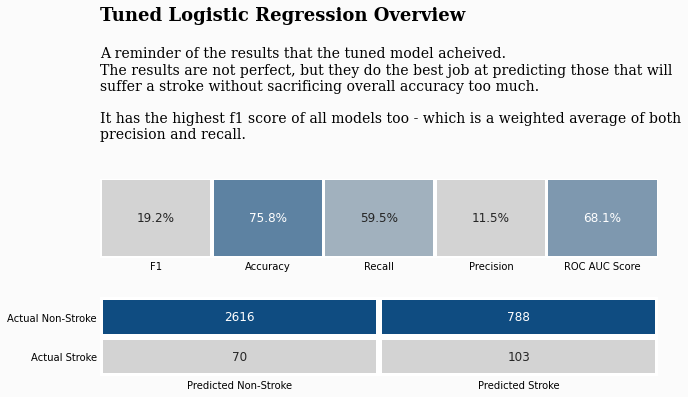

In [ ]:
colors = ["lightgray","lightgray","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,8)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])

sns.heatmap(lr_df.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95,yticklabels='', linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

ax0.text(0,-2,'Tuned Logistic Regression Overview',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.text(0,-0.3,
'''
A reminder of the results that the tuned model acheived.
The results are not perfect, but they do the best job at predicting those that will
suffer a stroke without sacrificing overall accuracy too much.

It has the highest f1 score of all models too - which is a weighted average of both
precision and recall.
''',fontsize=14,fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)



# Overall

sns.heatmap(logreg_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax1,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],vmax=500,vmin=0,xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})
ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

# Model Interpretation

I'll use some valuable tools which help to uncover the supposed "Black Box" of machine learning algorithms.

As I always say, the models we create need to be sold to business stakeholders. And if business stakeholders don't understand what we're creating, they may be less likely to back the project.

# Bonus: Dive in to Random Forest's performance

As the model with the highest 'accuracy' (not the best metric for this project), I thought I would include a little more analysis so we can see how the Random Forest makes its predictions.

In [ ]:

def rf_feat_importance(m, df):
    return pd.DataFrame({'Feature':df.columns, 'Importance':m.feature_importances_}).sort_values('Importance', ascending=False)


fi = rf_feat_importance(rf_pipeline['RF'], X)
fi[:10].style.background_gradient(cmap=colormap)

,Feature,Importance
1,age,0.410249
6,bmi,0.214319
5,avg_glucose_level,0.199155
4,work_type,0.079523
0,gender,0.064533
2,hypertension,0.019529
3,heart_disease,0.012691


Let's plot this with the top 3 features highlighted

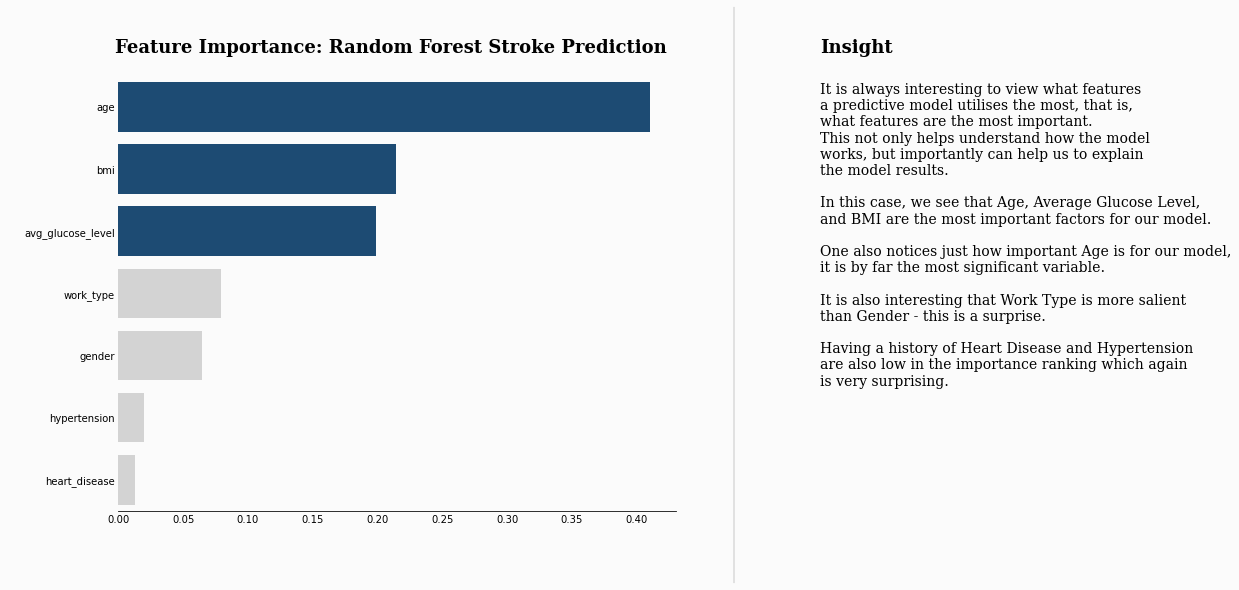

In [ ]:
background_color = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 8),facecolor=background_color)

color_map = ['lightgray' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  '#0f4c81' # color highlight

sns.barplot(data=fi,x='Importance',y='Feature',ax=ax,palette=color_map)
ax.set_facecolor(background_color)
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

fig.text(0.12,0.92,"Feature Importance: Random Forest Stroke Prediction", fontsize=18, fontweight='bold', fontfamily='serif')


plt.xlabel(" ", fontsize=12, fontweight='light', fontfamily='serif',loc='left',y=-1.5)
plt.ylabel(" ", fontsize=12, fontweight='light', fontfamily='serif')


fig.text(1.1, 0.92, 'Insight', fontsize=18, fontweight='bold', fontfamily='serif')

fig.text(1.1, 0.315, '''
It is always interesting to view what features
a predictive model utilises the most, that is,
what features are the most important.
This not only helps understand how the model
works, but importantly can help us to explain
the model results.

In this case, we see that Age, Average Glucose Level,
and BMI are the most important factors for our model.

One also notices just how important Age is for our model,
it is by far the most significant variable.

It is also interesting that Work Type is more salient
than Gender - this is a surprise.

Having a history of Heart Disease and Hypertension
are also low in the importance ranking which again
is very surprising.
'''
         , fontsize=14, fontweight='light', fontfamily='serif')

ax.tick_params(axis=u'both', which=u'both',length=0)


import matplotlib.lines as lines
l1 = lines.Line2D([0.98, 0.98], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])


plt.show()

# We can also use SHAP

SHAP Values (SHapley Additive exPlanations) break down a prediction to show the impact of each feature.

It interprets the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value (e.g. zero)


In this case I will use it for the Random Forest Model. It can be used for any type of model but it is by far the quickest with tree based models.

It is possible to change the colour values in SHAP plots too


In [ ]:
# great resource: https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values
import shap

explainer = shap.TreeExplainer(rfc)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_test)


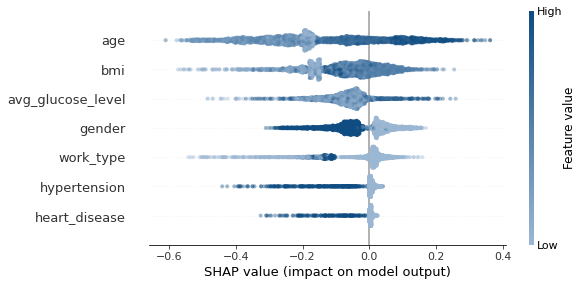

In [ ]:
# custom colour plot
colors = ["#9bb7d4", "#0f4c81"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
shap.summary_plot(shap_values[1], X_test,cmap=cmap,alpha=0.4)


# SHAP explained

The plot above shows the effext of each data point on our predictions.

For example, for age, the top left point reduced the prediction by 0.6.

The color shows whether that feature was high or low for that row of the dataset
Horizontal location shows whether the effect of that value caused a higher or lower prediction.


We can also see how our Random Forest Model is heavily skewed in favour of predicting no-strokes.

# There's more? SHAP dependence plots

We can also focus on how the impact of each variable changes, as the variable itself changes.

For instance, Age. When this variable increases, the SHAP value also increases - pushing the patient closer to  our 1 condition (stroke).

This is also shown with colour -  pink/red representing those who suffered a stroke.

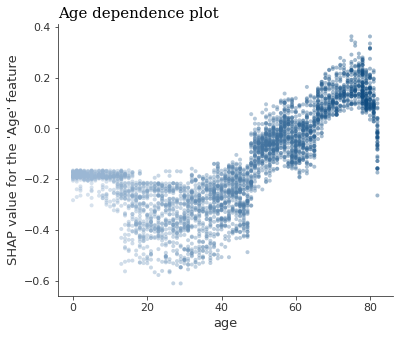

In [ ]:

shap.dependence_plot('age', shap_values[1], X_test, interaction_index="age",cmap=cmap,alpha=0.4,show=False)
plt.title("Age dependence plot",loc='left',fontfamily='serif',fontsize=15)
plt.ylabel("SHAP value for the 'Age' feature")
plt.show()

The same plot, but with a more interesting varibale.

Here we see a clear cutoff point for when strokes become far more common - after a BMI of around 30 or so.

Such is the power of SHAP visualization.

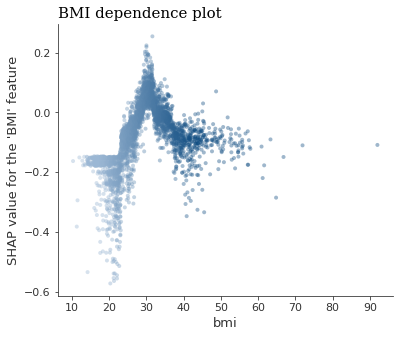

In [ ]:
shap.dependence_plot('bmi', shap_values[1], X_test, interaction_index="bmi",cmap=cmap,alpha=0.4,show=False)
plt.title("BMI dependence plot",loc='left',fontfamily='serif',fontsize=15)
plt.ylabel("SHAP value for the 'BMI' feature")
plt.show()

# One-Step Further: Logistic Regression with LIME

When it comes to model interpretation, sometimes it is useful to unpack and focus on one example at a time.

The LIME package enables just that.

Lime stands for Local Interpretable Model-agnostic Explanations - here's an example:

In [ ]:
import lime
import lime.lime_tabular

# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(X.values, feature_names=X.columns.values.tolist(),
                                                  class_names=['stroke'], verbose=True, mode='classification')

In [ ]:
# Choose the jth instance and use it to predict the results for that selection
j = 1
exp = explainer.explain_instance(X.values[j], logreg_pipeline.predict_proba, num_features=5)


Intercept 0.11525685928302917
Prediction_local [0.29804877]
Right: 0.482912541995999


In [ ]:
# Show the predictions
exp.show_in_notebook(show_table=True)

# We can also use ELI5 for feature explanation

ELI5 stands for Explain it like I am 5 - a quirky name!

Here we see the coefficient for each variable - in other words, what our Logistic model puts most value in.

In [ ]:
import eli5

columns_ = ['gender', 'age', 'hypertension', 'heart_disease', 'work_type',
       'avg_glucose_level', 'bmi']

eli5.show_weights(logreg_pipeline.named_steps["LR"], feature_names=columns_)

Weight?,Feature
+1.990,age
+0.212,bmi
+0.182,avg_glucose_level
-0.292,heart_disease
-0.361,work_type
-0.390,hypertension
-0.394,<BIAS>
-0.753,gender
